In [70]:
!pip install catboost

     |████████████████████████████████| 66.3MB 57kB/s 


In [174]:
import numpy as np
import pandas as pd
import random
import re

from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.metrics import r2_score
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer,  classification_report
import catboost as catb
#import xgboost as xgb, lightgbm as lgbm, catboost as catb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
sns.set_context("paper", font_scale=1.5)  
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 50)

In [117]:
train = pd.read_csv('course_project_train.csv',  encoding='utf-8')

In [118]:
test = pd.read_csv('course_project_test.csv',  encoding='utf-8')

In [119]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [120]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [121]:
train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,"482,087.00",NaN,0.00,11.00,26.30,"685,960.00",1.00,nan,1.00,debt consolidation,Short Term,"99,999,999.00","47,386.00","7,914.00",749.00,0
1,Own Home,"1,025,487.00",10+ years,0.00,15.00,15.30,"1,181,730.00",0.00,nan,0.00,debt consolidation,Long Term,"264,968.00","394,972.00","18,373.00",737.00,1
2,Home Mortgage,"751,412.00",8 years,0.00,11.00,35.00,"1,182,434.00",0.00,nan,0.00,debt consolidation,Short Term,"99,999,999.00","308,389.00","13,651.00",742.00,0
3,Own Home,"805,068.00",6 years,0.00,8.00,22.50,"147,400.00",1.00,nan,1.00,debt consolidation,Short Term,"121,396.00","95,855.00","11,338.00",694.00,0
4,Rent,"776,264.00",8 years,0.00,13.00,13.60,"385,836.00",1.00,nan,0.00,debt consolidation,Short Term,"125,840.00","93,309.00","7,180.00",719.00,0


In [122]:
train.shape, test.shape

((7500, 17), (2500, 16))

In [123]:
print(train['Credit Default'].sum())

2113


In [124]:
#проверяем, какие типы нужно изменить
train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
dtype: object

In [125]:
train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [ ]:
#years = train.get_dummies(train['Years in current job'])
#y = pd.get_dummies(train.['Years in current job'], prefix='years')
#train = train.join(y)

In [126]:
train['Years in current job'].fillna(train['Years in current job'].mode()[0], inplace=True)
test['Years in current job'].fillna(train['Years in current job'].mode()[0], inplace=True)

In [127]:
train.loc[(train['Years in current job'] == '< 1 year'), 'Years in current job'] = '0'
test.loc[(test['Years in current job'] == '< 1 year'), 'Years in current job'] = '0'

In [128]:
train['Years in current job'] = [re.sub('\D', '', item) for item in train['Years in current job']]
train['Years in current job'] = train['Years in current job'].astype(np.float64)

test['Years in current job'] = [re.sub('\D', '', item) for item in test['Years in current job']]
test['Years in current job'] = test['Years in current job'].astype(np.float64)

In [129]:
train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [130]:
home_ownership = pd.get_dummies(train['Home Ownership'], prefix='Owner')
home_ownership_test = pd.get_dummies(test['Home Ownership'], prefix='Owner')
home_ownership.head()


,Owner_Have Mortgage,Owner_Home Mortgage,Owner_Own Home,Owner_Rent
0,0,0,1,0
1,0,0,1,0
2,0,1,0,0
3,0,0,1,0
4,0,0,0,1


In [131]:
train = train.join(home_ownership)
test = test.join(home_ownership_test)


In [132]:
del train['Home Ownership']
del test['Home Ownership']

In [133]:
train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

In [134]:
Purpose = pd.get_dummies(train['Purpose'], prefix='Purpose')
Purpose_test = pd.get_dummies(test['Purpose'], prefix='Purpose')

In [135]:
train = train.join(Purpose)
test = test.join(Purpose_test)

In [136]:
del train['Purpose']
del test['Purpose']

In [137]:
train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [138]:
train['Term'] = train['Term'].replace({'Short Term':0, 'Long Term':1})
test['Term'] = test['Term'].replace({'Short Term':0, 'Long Term':1})

**Заполняем пропуски:**

In [139]:
train['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
train['Months since last delinquent'].fillna(train['Months since last delinquent'].median(), inplace=True)
train['Bankruptcies'].fillna(train['Bankruptcies'].median(), inplace=True)
train['Credit Score'].fillna(train['Credit Score'].median(), inplace=True)

test['Annual Income'].fillna(train['Annual Income'].median(), inplace=True)
test['Months since last delinquent'].fillna(train['Months since last delinquent'].median(), inplace=True)
test['Bankruptcies'].fillna(train['Bankruptcies'].median(), inplace=True)
test['Credit Score'].fillna(train['Credit Score'].median(), inplace=True)

**Обработка выбросов**

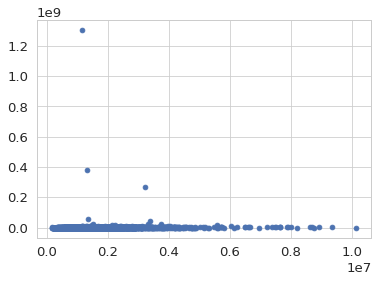

In [140]:
plt.scatter(train['Annual Income'], train['Maximum Open Credit'])

In [141]:
train['Maximum Open Credit'].max()
train.loc[(train['Maximum Open Credit'] > 200000000), 'Maximum Open Credit'] = train['Maximum Open Credit'].median()
test.loc[(test['Maximum Open Credit'] > 200000000), 'Maximum Open Credit'] = train['Maximum Open Credit'].median()

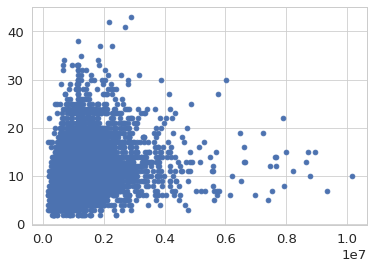

In [142]:
plt.scatter(train['Annual Income'], train['Number of Open Accounts'])


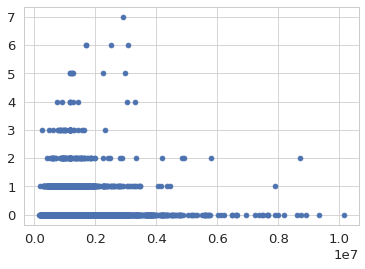

In [143]:
plt.scatter(train['Annual Income'], train['Number of Credit Problems'])


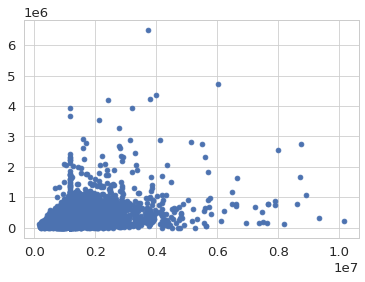

In [144]:
plt.scatter(train['Annual Income'], train['Current Credit Balance'])


In [145]:
train.loc[(train['Current Credit Balance'] > 4800000), 'Current Credit Balance'] = train['Current Credit Balance'].median()
test.loc[(test['Current Credit Balance'] > 4800000), 'Current Credit Balance'] = train['Current Credit Balance'].median()

**Построение модели**

In [158]:
target_name = ['Credit Default']
#после построения модели, просмотрела feature_importances_ и исключила наименее значимые
feature_names = [
   'Annual Income' ,
   'Years in current job' ,
   'Number of Open Accounts',
   'Years of Credit History'  ,
   'Maximum Open Credit'     ,
   'Months since last delinquent' ,
   'Term'                         ,  
   'Current Loan Amount'         ,
   'Current Credit Balance'       ,
   'Monthly Debt'                 ,
   'Credit Score'       

               ]

In [159]:
X = train[feature_names]
y = train[target_name]
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)
X_test = test[feature_names]

In [160]:
f1 = make_scorer(f1_score , average='micro')

In [115]:
# комментирую GridSearchCV, чтобы не замедлять работу проекта
#forest = RandomForestClassifier(max_depth=19, 
#                               max_features=6, 
#                               n_estimators=100,
#                              random_state=42)
#params = {
#    'n_estimators': [60],
#  'max_depth': [5,10,18],
#   'max_features': [ 10, 20, 30]
#}
#
#forest_grid = GridSearchCV(forest, params, scoring=f1, 
#                 cv=KFold(n_splits=10, random_state=42, shuffle=True), 
#                n_jobs=-1)
#forest_grid.fit(X, y)
#print(forest_grid.best_params_)
#print('f1 на train: {:.5f}'.format(forest_grid.best_score_))

{'max_depth': 10, 'max_features': 10, 'n_estimators': 60}
f1 на train: 0.78013


In [102]:
#Комментирую вычисление важности признаков

#forest_best = forest_grid.best_estimator_
#importances = forest_best.feature_importances_
#feat_importances = pd.Series(importances, index=feature_names)
#feat_importances.sort_values(ascending=True, inplace=True)


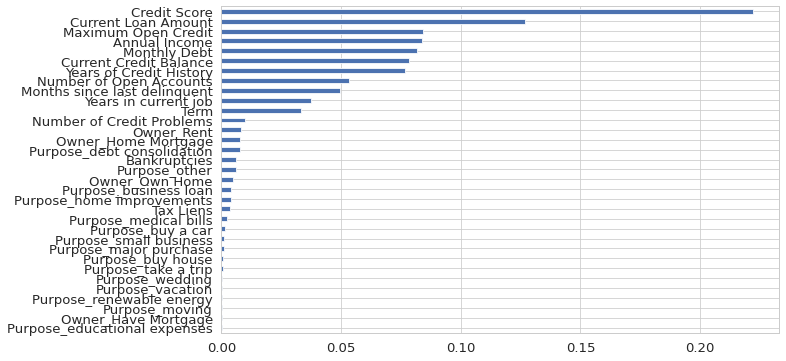

In [103]:
#feat_importances.plot(kind='barh', figsize=(10, 6));

In [169]:
#строим лес с лучшими параметрами
my_forest = RandomForestClassifier(max_depth=15, 
                              max_features=10, 
                               n_estimators=60,
                               random_state=42)
my_forest.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [170]:
y_pred = my_forest.predict(X_train)

In [172]:
y_pred_val = my_forest.predict(X_val)


**`Проверка точности на трейне и валидационных данных`**

In [77]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


In [173]:
get_classification_report(y_train, y_pred, y_val, y_pred_val)

TRAIN

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3771
           1       1.00      0.75      0.86      1479

    accuracy                           0.93      5250
   macro avg       0.96      0.87      0.90      5250
weighted avg       0.94      0.93      0.93      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1616
           1       0.72      0.33      0.45       634

    accuracy                           0.77      2250
   macro avg       0.75      0.64      0.65      2250
weighted avg       0.76      0.77      0.74      2250



In [156]:
#пробовала CatBoostClassifier, но получила худшие значения: 

#final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=5,
#                                      silent=True,
#                                      #l2_leaf_reg = 10, 
#                                      #scale_pos_weight = scale,                                      
#                                      random_state=21)
#final_model.fit(X_train, y_train)
#
#y_train_pred = final_model.predict(X_train)
#y_val_pred = final_model.predict(X_val)
#
#get_classification_report(y_train, y_train_pred, y_val, y_val_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.99      0.90      3771
           1       0.96      0.47      0.63      1479

    accuracy                           0.85      5250
   macro avg       0.89      0.73      0.77      5250
weighted avg       0.86      0.85      0.83      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.96      0.86      1616
           1       0.72      0.29      0.41       634

    accuracy                           0.77      2250
   macro avg       0.75      0.62      0.63      2250
weighted avg       0.76      0.77      0.73      2250



In [179]:
#предсказание для теста
X_test = test[feature_names]
y_test = my_forest.predict(X_test)
preds = pd.DataFrame()
preds['Credit Default'] = y_test
preds.to_csv('JuliaGribova_predictions.csv', index=False)